# Auto GM: Capstone Project for DSI-824 for General Assembly

**Imports**

In [203]:
## standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs

#auto EDA packages
import sweetviz as sv
from pandas_profiling import ProfileReport

#modeling imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#statsmodel imports
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#sktime models
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.compose import EnsembleForecaster

#RNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# metrics
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score

#model export
import pickle

### Read in Data

Data was collected from a POS system online repository for a small business auto repair store in Fort Worth, TX. The dates used are 01.01.2017 through 11.13.2020 (weekend before project deadline). Future iterations of this project will have current data uploading to a cloud repository, where it will then be brought into the app for up to date modeling. 

In [94]:
df = pd.read_csv('./data/206/Daily Sales by Store-2017-to-Nov13-2020.csv')

In [95]:
df.head()

,Store Number,Date,Gross Amount,Net Amount,Store Ticket Net Amount,Warranty Amount,Average Included Bay Time,Store Ticket Count,Store Ticket Average Net,Promotion Amount
0,206,01/02/2017,"$7,799.61","$7,453.30","$7,446.30",$194.45,15.1,95,$78.38,$151.86
1,NaN,01/03/2017,"$6,511.63","$6,339.58","$6,314.60",$0.00,17.1,66,$95.68,$172.05
2,NaN,01/04/2017,"$6,479.13","$6,284.53","$6,284.53",$162.99,15.8,48,$130.93,$31.61
3,NaN,01/05/2017,"$5,965.92","$5,364.06","$5,326.08",$409.43,20.9,58,$91.83,$192.43
4,NaN,01/06/2017,"$4,576.93","$4,361.67","$4,185.35",$173.08,17.6,47,$89.05,$42.18


In [96]:
df.columns

Index(['Store Number', 'Date', 'Gross Amount', 'Net Amount',
       'Store Ticket Net Amount', 'Warranty Amount',
       'Average Included Bay Time', 'Store Ticket Count',
       'Store Ticket Average Net', 'Promotion Amount'],
      dtype='object')

A portion of this project will be to create a dashboard for the business. I am using the Net Amount and Store Ticket Count columns for the MVP version of this project. I will expand to more KPI's in later versions. 

In [97]:
df.drop(columns=(['Store Number', 'Gross Amount','Store Ticket Net Amount', 'Warranty Amount',
       'Average Included Bay Time', 'Store Ticket Average Net', 'Promotion Amount']), inplace=True)

In [98]:
df['Date'] = pd.to_datetime(df['Date'])

In [99]:
df.set_index('Date', inplace=True)

In [100]:
# Money reads in as an object datatype, so we must remove the $ symbol from the string, and the "," 
# inspiration from https://pbpython.com/currency-cleanup.html
df['Net Amount'] = df['Net Amount'].str.replace('$', '').str.replace(',', '')

In [101]:
# Convert to numeric datatype from object 
df['Net Amount'] = pd.to_numeric(df['Net Amount'])

In [102]:
# Round values for readibility and cast as Int datatype
df['Net Amount']= df['Net Amount'].astype(int).round()

In [103]:
df.head(), df.tail()

(            Net Amount Store Ticket Count
 Date                                     
 2017-01-02        7453                 95
 2017-01-03        6339                 66
 2017-01-04        6284                 48
 2017-01-05        5364                 58
 2017-01-06        4361                 47,
             Net Amount Store Ticket Count
 Date                                     
 2020-11-11        3832                 47
 2020-11-12        7858                 50
 2020-11-13       10962                 61
 NaT            8757109             83,261
 NaT            8757109             83,261)

In [104]:
df.shape

(1398, 2)

In [105]:
# slice off the total columns at end of dataset
df = df.iloc[:1396]

In [106]:
df.tail()

,Net Amount,Store Ticket Count
Date,,
2020-11-09,6144,51
2020-11-10,6518,48
2020-11-11,3832,47
2020-11-12,7858,50
2020-11-13,10962,61


### EDA

In [107]:
# EDA for the MVP is quite light with only two variables being analyzed. 

In [108]:
# EDA on clean dataset with Pandas Profiling EDA package
profile = ProfileReport(df, title="Pandas Profiling Report")
profile

In [109]:
# clean copy of cleaned dataset
dash = df.copy()

In [157]:
dash.to_csv('./datasets/Dashboard.csv')

In [110]:
dash.head()

,Net Amount,Store Ticket Count
Date,,
2017-01-02,7453,95
2017-01-03,6339,66
2017-01-04,6284,48
2017-01-05,5364,58
2017-01-06,4361,47


In [201]:
dash.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1396 entries, 2017-01-02 to 2020-11-13
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Net Amount          1396 non-null   int32 
 1   Store Ticket Count  1396 non-null   object
dtypes: int32(1), object(1)
memory usage: 27.3+ KB


In [202]:
dash_2020 = dash.loc['2020']
dash_2020

,Net Amount,Store Ticket Count
Date,,
2020-01-02,8981,65
2020-01-03,8186,70
2020-01-04,10397,82
2020-01-05,2848,39
2020-01-06,8012,73
...,...,...
2020-11-09,6144,51
2020-11-10,6518,48
2020-11-11,3832,47


In [177]:
year_index = len(dash.loc['2020'])
year_index

316

In [184]:
YTD = dash.groupby(pd.Grouper(freq='M'))
YTD.head()

,Net Amount,Store Ticket Count
Date,,
2017-01-02,7453,95
2017-01-03,6339,66
2017-01-04,6284,48
2017-01-05,5364,58
2017-01-06,4361,47
...,...,...
2020-11-01,8239,47
2020-11-02,6117,67
2020-11-03,8392,66


In [200]:
#{'Net Amount': 'sum'}
dash_YTD = dash['Net Amount'].loc['2020'].agg('sum') 
dash_YTD

1925326

In [199]:
dash_MTD = dash.dt.month.agg('sum')

AttributeError: 'DataFrame' object has no attribute 'dt'

In [ ]:
dash['YTDTotal'] = df.groupby('FinancialYearStart')['SalesTotal'].cumsum()

In [196]:
dash.loc['2020']

,Net Amount,Store Ticket Count
Date,,
2020-01-02,8981,65
2020-01-03,8186,70
2020-01-04,10397,82
2020-01-05,2848,39
2020-01-06,8012,73
...,...,...
2020-11-09,6144,51
2020-11-10,6518,48
2020-11-11,3832,47


In [179]:
YTD = dash                 .groupby(['Platform', 'Year', 'Geo']).agg({'Sales': 'sum'}).reset_index()

,Net Amount,Store Ticket Count
Date,,
2017-01-02,7453,95
2017-01-03,6339,66
2017-01-04,6284,48
2017-01-05,5364,58
2017-01-06,4361,47
...,...,...
2017-11-11,6961,81
2017-11-12,5230,52
2017-11-13,6078,52


### Modeling 

In [111]:
# Train/ Test Split

In [112]:
train = df.loc[:'2018'] 

In [113]:
# split training set for each feature 
train_net = train['Net Amount']
train_cc = train['Store Ticket Count']

In [114]:
train_net.shape

(720,)

In [115]:
train_net = train_net.astype(np.int64)

In [116]:
train_net.value_counts()

3654     3
5596     2
5230     2
12235    2
4034     2
        ..
5794     1
5793     1
7985     1
11932    1
9807     1
Name: Net Amount, Length: 693, dtype: int64

In [117]:
train_net.head(), train_net.tail()

(Date
 2017-01-02    7453
 2017-01-03    6339
 2017-01-04    6284
 2017-01-05    5364
 2017-01-06    4361
 Name: Net Amount, dtype: int64,
 Date
 2018-12-27    8208
 2018-12-28    6564
 2018-12-29    7791
 2018-12-30    5011
 2018-12-31    4730
 Name: Net Amount, dtype: int64)

In [118]:
test = df.loc['2019'] 

In [119]:
# split training set for each feature 
test_net = test['Net Amount']
test_cc = test['Store Ticket Count']

In [120]:
test_net.shape

(360,)

In [121]:
test_net = test_net.astype(np.int64)

In [122]:
train_net.tail, test_net.head(),

(<bound method NDFrame.tail of Date
 2017-01-02    7453
 2017-01-03    6339
 2017-01-04    6284
 2017-01-05    5364
 2017-01-06    4361
               ... 
 2018-12-27    8208
 2018-12-28    6564
 2018-12-29    7791
 2018-12-30    5011
 2018-12-31    4730
 Name: Net Amount, Length: 720, dtype: int64>,
 Date
 2019-01-02    3604
 2019-01-03    5137
 2019-01-04    8838
 2019-01-05    9286
 2019-01-06    4279
 Name: Net Amount, dtype: int64)

In [123]:
train_net.shape, test_net.shape

((720,), (360,))

In [124]:
# put together train/test in order to reset index 
df2 = pd.concat([train_net, test_net], axis=0 )

In [125]:
df2.iloc[718:725]

Date
2018-12-30    5011
2018-12-31    4730
2019-01-02    3604
2019-01-03    5137
2019-01-04    8838
2019-01-05    9286
2019-01-06    4279
Name: Net Amount, dtype: int64

In [126]:
# reset index in order to model data 
df2 = df2.reset_index(drop=True)

((720,), (360,))

In [129]:
df2.iloc[718:725]

718    5011
719    4730
720    3604
721    5137
722    8838
723    9286
724    4279
Name: Net Amount, dtype: int64

In [130]:
# split back out train/test
y_train_net = df2.iloc[:720]
y_test_net = df2.iloc[720:]

In [131]:
len(y_train_net.index)

720

In [132]:
## Verify numbers with original train set
y_train_net.head(), y_train_net.tail()

(0    7453
 1    6339
 2    6284
 3    5364
 4    4361
 Name: Net Amount, dtype: int64,
 715    8208
 716    6564
 717    7791
 718    5011
 719    4730
 Name: Net Amount, dtype: int64)

In [133]:
# Verify numbers with original test set
y_test_net.head(), y_test_net.tail()

(720    3604
 721    5137
 722    8838
 723    9286
 724    4279
 Name: Net Amount, dtype: int64,
 1075    9252
 1076    5504
 1077    5255
 1078    7505
 1079    9298
 Name: Net Amount, dtype: int64)

In [134]:
y_test_net.shape, y_train_net.shape

((360,), (720,))

In [135]:
# autocorrelation of training set
print(y_train_net.autocorr(lag=7),
y_train_net.autocorr(lag=14),y_train_net.autocorr(lag=21))

0.26636977717675675 0.25873736045479134 0.23568770898336733


Lags in intervals of 7 show the highest autocorrelation, which makes sense because this data is derived from a small business with predictable weekday trends. 

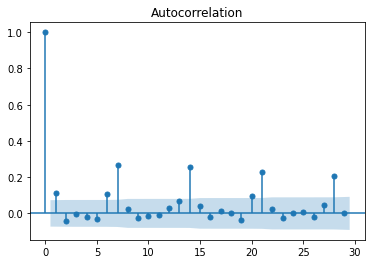

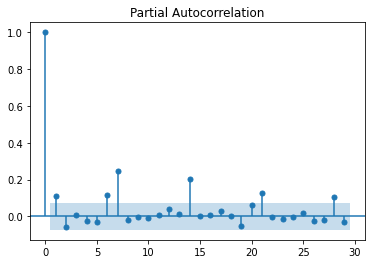

In [136]:
#ACF and PACF plots
plot_acf(y_train_net),

plot_pacf(y_train_net);

Enough points in the ACF plot lie outside the 95% confidence interval to suggest the time series is not white noise, rather, the lollipops that extend past the confidence interval and in repeating sequence show the series has some seasonality to it. 

#### Naive (Mean) 
This is a highly relevant naive model, because the mean is used quite often in this industry to calculate trends, which then our used to forecast

In [137]:
naive_model_mean = NaiveForecaster(strategy='mean')

In [138]:
naive_model_mean.fit(y_train_net)
y_mean_preds = naive_model_mean.predict(list(range(1, len(y_test_net)+1)))

In [204]:
with open("naive_model_mean.pkl", "wb") as file:
    pickle.dump(naive_model_mean, file)

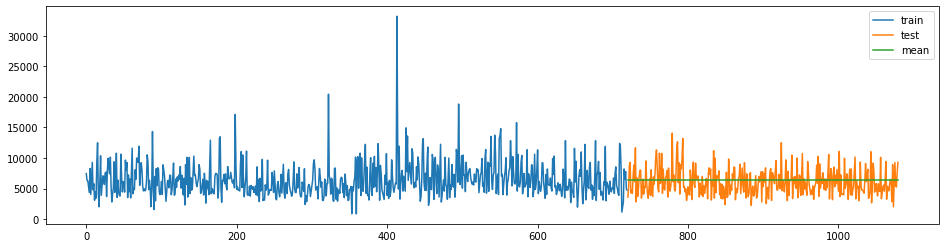

In [139]:
plot_ys(y_train_net, y_test_net, y_mean_preds, labels=['train', 'test', 'mean']);

In [140]:
naive_model_season = NaiveForecaster(strategy='last', sp=12)
naive_model_season.fit(y_train_net)
y_season_preds = naive_model_season.predict(list(range(1, len(y_test_net)+1)))

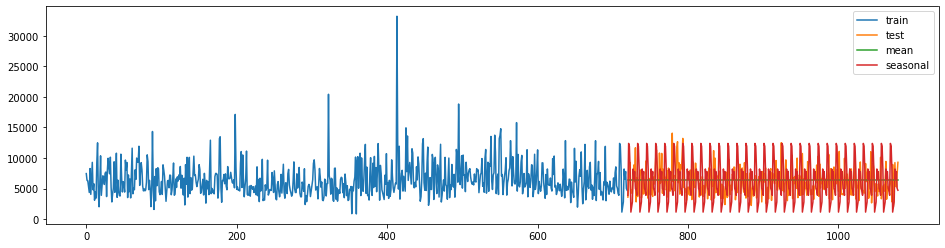

In [141]:
plot_ys(y_train_net, y_test_net, y_mean_preds, y_season_preds, labels=['train', 'test', 'mean', 'seasonal']);

#### Holt Winters (StatsModels)

In [142]:
hw = ExponentialSmoothing(y_train_net,seasonal_periods = 7).fit()

c:\users\cmo\anaconda3\envs\sktime\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\users\cmo\anaconda3\envs\sktime\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [143]:
hw_preds = hw.forecast(len(y_test_net))

In [205]:
with open("hw_preds.pkl", "wb") as file:
    pickle.dump(hw_preds, file)

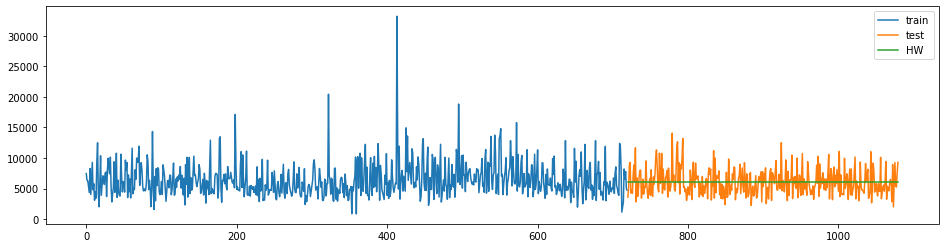

In [144]:
plot_ys(y_train_net, y_test_net, hw_preds, labels=['train', 'test', 'HW']);

#### Sarima (SKTime) 

In [229]:
y_train_net

0      7453
1      6339
2      6284
3      5364
4      4361
       ... 
715    8208
716    6564
717    7791
718    5011
719    4730
Name: Net Amount, Length: 720, dtype: int64

In [206]:
sarima_model = AutoARIMA(sp=12, suppress_warnings=True)

In [207]:
sarima_model.fit(y_train_net)

AutoARIMA(sp=12, suppress_warnings=True)

In [208]:
with open("sarima_model.pkl", "wb") as file:
    pickle.dump(sarima_model, file)

In [209]:
y_sarima = sarima_model.predict(np.arange(len(y_test_net)) + 1)

In [210]:
mae_sarima = mae(y_test_net, y_sarima)
mae_sarima

1739.579551093725

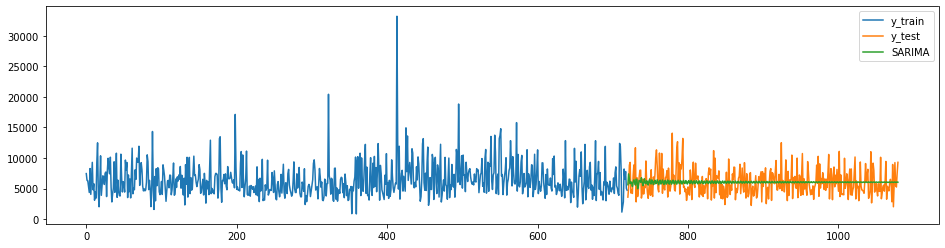

In [211]:
plot_ys(y_train_net, y_test_net, y_sarima, labels=['y_train', 'y_test', 'SARIMA']);

#### SarimaX

#### Ensemble Forecaster

In [92]:
forecaster = EnsembleForecaster([
        ('sarima', sarima_model),
        ('hw', hw)
        ],
    n_jobs=-1
)

NameError: name 'sarima_model' is not defined

In [206]:
forecaster.fit(y_train_net)

ValueError: Buffer dtype mismatch, expected 'float64_t' but got 'long long'

In [ ]:
preds = forecaster.predict(list(range(1, len(y_test_net)+1)))

In [ ]:
plot_ys(y_train_net, y_test_net, preds, labels=['y_train', 'y_test', 'Ensemble']);

#### RNN 

In [ ]:
not sure what x and y would be 

In [ ]:
# Create X and y
X= y_train_net
y= y_test_net

In [ ]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [ ]:
# Scale
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [ ]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_ss, y_train, length=3, batch_size=64)

In [ ]:
batch_x, batch_y = train_sequences[0]

In [ ]:
pd.DataFrame(X_train_ss, columns = X_train.columns).head()

In [ ]:
# Create test sequences
test_sequences = TimeseriesGenerator(X_test_ss, y_test, length=3, batch_size=64)

In [ ]:
# Design RNN
model = Sequential()
model.add(GRU(8, input_shape=(3,8), return_sequences = True))
model.add(GRU(8, return_sequences= False))

model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=Adam(lr=0.0005), loss='binary_crossentropy', 
             metrics = ['acc'])

In [ ]:
history = model.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc']);

#### Scoring (MAE)

In [233]:
# Naive(mean)
mae_naive_mean = mae(y_test_net, y_mean_preds)
mae_naive_mean

1790.358086419753

In [91]:
# Naive(seasonal)
mae_naive_seasonal = mae(y_test_net, y_season_preds)
mae_naive_seasonal

3258.927777777778

In [118]:
# Holt Winters
mae_hw = mae(y_test_net, hw_preds)
mae_hw

2623.6659098142763

In [202]:
# Sarima sp=12
mae_sarima = mae(y_test_net, y_sarima)
mae_sarima

1739.579551093725

In [ ]:
#RNN 

#### Best Model Predictions (Sarima)

--- Net Sales Model --- 

In [247]:
dash = dash.reset_index(drop=True)

In [233]:
# TTS on sales
y_train_sales, y_test_sales = temporal_train_test_split(dash['Net Amount'], test_size=.20)

In [234]:
# get shapes to split later
y_train_sales.shape, y_test_sales.shape

((1116,), (280,))

In [240]:
y_test_sales

1116     7149
1117     9438
1118     5064
1119     5826
1120     3833
        ...  
1391     6144
1392     6518
1393     3832
1394     7858
1395    10962
Name: Net Amount, Length: 280, dtype: int32

In [235]:
# put together train/test in order to reset index 
df_sales = pd.concat([y_train_sales, y_test_sales], axis=0 )

In [236]:
#reset index 
df_sales = df_sales.reset_index(drop=True)

In [237]:
# split back out train/test
y_train_sales = df_sales.iloc[:1116]
y_test_sales = df_sales.iloc[1116:]

In [249]:
# sales prediction model 
sarima_predict = AutoARIMA(sp=12, suppress_warnings=True)
sarima_predict.fit(dash['Net Amount'])

AutoARIMA(sp=12, suppress_warnings=True)

In [266]:
# 7 day predictions
sarima_seven_sales = sarima_predict.predict(list(range(1, 8)))
round(sarima_seven_sales), round(sarima_seven_sales).agg('sum')

(1396    7297.0
 1397    6293.0
 1398    6631.0
 1399    7060.0
 1400    6312.0
 1401    6442.0
 1402    7153.0
 dtype: float64,
 47188.0)

In [274]:
sarima_seven_sales = pd.DataFrame(sarima_seven_sales)
# sarima_seven_sales = pd.to_datetime(sarima_seven_sales)
# sarima_seven_sales.rename(columns={"O": "Net Sales"})
sarima_seven_sales.to_csv('./datasets/7-day-preds.csv')

In [260]:
# 30 day predictions
sarima_30_sales = sarima_predict.predict(list(range(1, 31)))
round(sarima_30_sales), round(sarima_30_sales).agg('sum')

(1396    7297.0
 1397    6293.0
 1398    6631.0
 1399    7060.0
 1400    6312.0
 1401    6442.0
 1402    7153.0
 1403    6705.0
 1404    5652.0
 1405    6540.0
 1406    6963.0
 1407    6147.0
 1408    6204.0
 1409    6984.0
 1410    6666.0
 1411    5459.0
 1412    6706.0
 1413    6934.0
 1414    6032.0
 1415    6226.0
 1416    7102.0
 1417    6761.0
 1418    5663.0
 1419    6252.0
 1420    6857.0
 1421    5959.0
 1422    6243.0
 1423    6974.0
 1424    6422.0
 1425    5899.0
 dtype: float64,
 194538.0)

In [276]:
sarima_30_sales = pd.DataFrame(sarima_30_sales)
sarima_30_sales.to_csv('./datasets/30-day-preds.csv')

In [277]:
# 90 day predictions
sarima_90_sales = sarima_predict.predict(list(range(1, 91)))
round(sarima_90_sales), round(sarima_90_sales).agg('sum')

(1396    7297.0
 1397    6293.0
 1398    6631.0
 1399    7060.0
 1400    6312.0
          ...  
 1481    6309.0
 1482    6749.0
 1483    6500.0
 1484    6185.0
 1485    6575.0
 Length: 90, dtype: float64,
 583099.0)

In [278]:
sarima_90_sales = pd.DataFrame(sarima_90_sales)
sarima_90_sales.to_csv('./datasets/90-day-preds.csv')

--- Car Count Model ---

In [223]:
# TTS on car count
y_train_cars, y_test_cars = temporal_train_test_split(dash['Store Ticket Count'], test_size=.20)

In [224]:
# get shapes to split later
y_train_cars.shape, y_test_cars.shape

AutoARIMA(sp=12, suppress_warnings=True)

In [228]:
# put together train/test in order to reset index 
df_cars = pd.concat([y_train_cars, y_test_cars], axis=0 )

TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

In [ ]:
#reset index 
df_cars = df_cars.reset_index(drop=True)

In [ ]:
# split back out train/test
y_train_cars = df_cars.iloc[:1116]
y_test_cars = df_cars.iloc[1116:]

In [ ]:
# car count prediction model 
sarima_predict = AutoARIMA(sp=12, suppress_warnings=True)
sarima_predict.fit(y_train_cars)

TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

In [ ]:
# 1 month

In [ ]:
# 3 month